In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import models
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Load data
# path = 'C:/Users/akshg/Desktop/Emotion CNN/'
data = pd.read_csv('icml_face_data.csv')

# Drop 'surprise' and 'disgust' labels
data = data[(data['emotion'] != 5) & (data['emotion'] != 1)]

# Update emotions dictionary
emotions = {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Sad', 4: 'Neutral'}

In [5]:
# Function to prepare data
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 3))  # Update shape to (48, 48, 3)
    image_label = np.array(list(map(int, data['emotion'])))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image = np.stack((image,) * 3, axis=-1)  # Convert grayscale to RGB
        image_array[i] = image
    return image_array, image_label

# Prepare data splits
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

# Preprocess data
train_images = train_image_array.astype('float32') / 255
val_images = val_image_array.astype('float32') / 255
test_images = test_image_array.astype('float32') / 255

# Remove labels for 'surprise' and 'disgust'
train_labels = to_categorical(train_image_label, num_classes=7)[:, [0, 2, 3, 4, 6]]
val_labels = to_categorical(val_image_label, num_classes=7)[:, [0, 2, 3, 4, 6]]
test_labels = to_categorical(test_image_label, num_classes=7)[:, [0, 2, 3, 4, 6]]

In [6]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Add custom classification head
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(5, activation='softmax')(x)  # Output layer with 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

# Train the model
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=15,
                    batch_size=32)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [8]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

98/98 [==============================] - 24s 248ms/step - loss: 1.3554 - accuracy: 0.4516
Test accuracy: 0.451571524143219


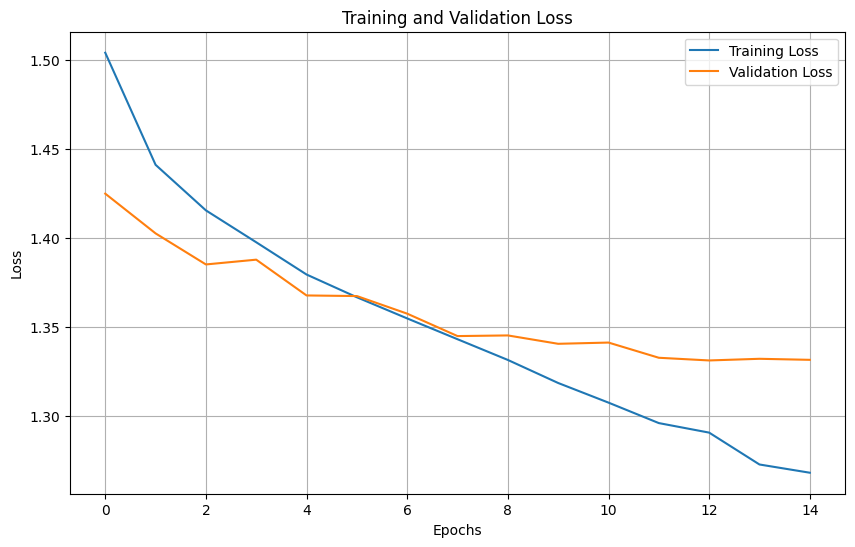

In [9]:
# Plot training/validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

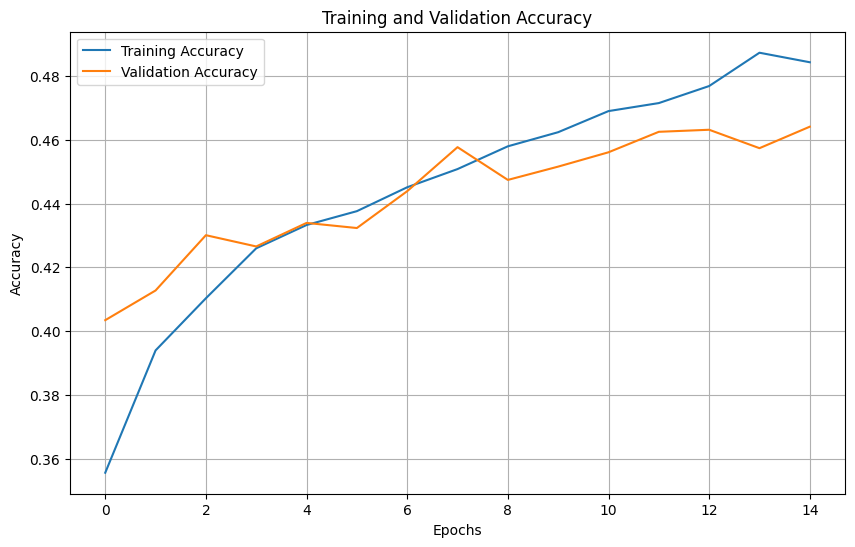

In [10]:
# Plot training/validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()